In [5]:
# ====================================================
# 🔧 Environment Setup
# ====================================================
import torch, os
from transformers import AutoTokenizer
from scmt.modeling_somt import SchemaAugmentedSOMT
from scmt.modeling_utils import visualize_schemas
from scmt.schema_analysis import analyze_schemas
from scmt.viz_schemas import visualize_schemas as visualize_schemas_enhanced
from scmt.explain import generate_with_schema_attribution, schema_ablation_test
from FastChemTokenizerHF import FastChemTokenizerSelfies


# Path to the model checkpoint 
model_path = "./checkpoint_1/checkpoints_1/somt_mol_run_1/"

# Load model and tokenizer
model = SchemaAugmentedSOMT.from_pretrained(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu")
tokenizer = FastChemTokenizerSelfies.from_pretrained("./tokenizer_vocab/selftok_reordered")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print(f"✅ Model loaded on {device}")


✅ Special tokens bound: 0 1 2 3 4
✅ Model loaded on cuda


In [6]:
# Basic textual interpretation
visualize_schemas(model, tokenizer, top_k=10)



=== Schema Interpretability (top 10 tokens per schema) ===

Schema 00: [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] (0.239) | [Br] [C] (0.224) | [C] [C] [=Branch1] [C] [=O] (0.171) | [O] [C] [C] [=C] (0.155) | [C] [=C] [C] (0.144) | [C] [C] [O] [C] [=Branch1] [C] [=O] [C] (0.139) | [O] [=C] [Branch1] [C] [O] [C] [=C] [C] (0.138) | [C] [C] [=C] [C] [=C] [Branch2] [Ring2] (0.137) | [C] [C] [C] [=Branch1] [C] [=O] [N] [C] (0.134) | [C] [O] [C] [C] [N] [C] (0.122)
Schema 01: [C] [C] [=C] [C] [=C] [C] (0.139) | [C] [O] [C] [=C] [C] [=C] [Branch1] (0.129) | [O] [C] (0.124) | [N] [C] (0.114) | [C] [#C] [C] (0.113) | [F] (0.110) | [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring1] (0.096) | [C] [O] [C] [=C] [C] [=C] [C] [=C] (0.095) | [C] [C] [O] [C] (0.095) | </s> (0.090)
Schema 02: [C] [C] [Branch1] [C] [C] [C] (0.175) | [C] [C] [C] [Branch1] [C] [C] (0.166) | [C] [O] [C] [=C] [C] [=C] [Branch2] [Ring2] (0.146) | [C] [C] [=C] [C] [=C] [C] (0.145) | [C] [O] [C] [C] [N] [C] (0.136) | [C] [C] [C] [=C]


🔍 Schema 0


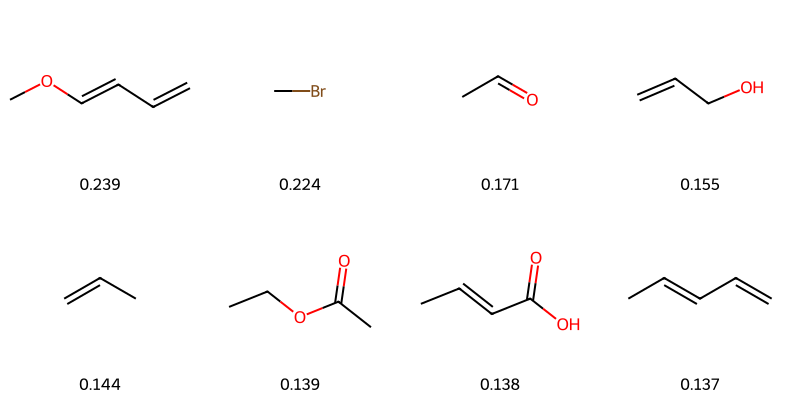


🔍 Schema 1


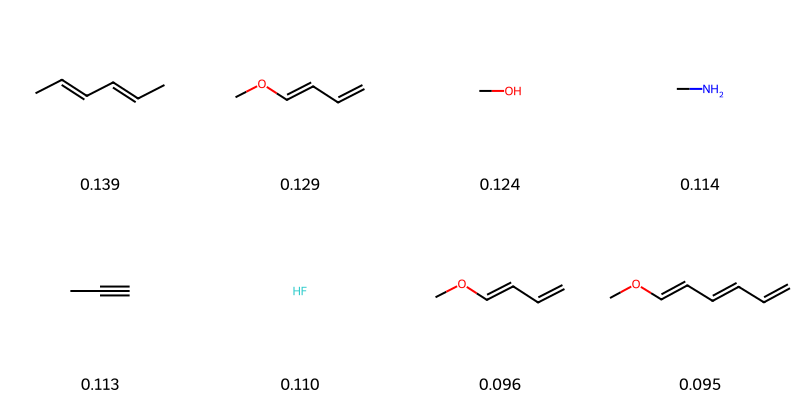


🔍 Schema 2


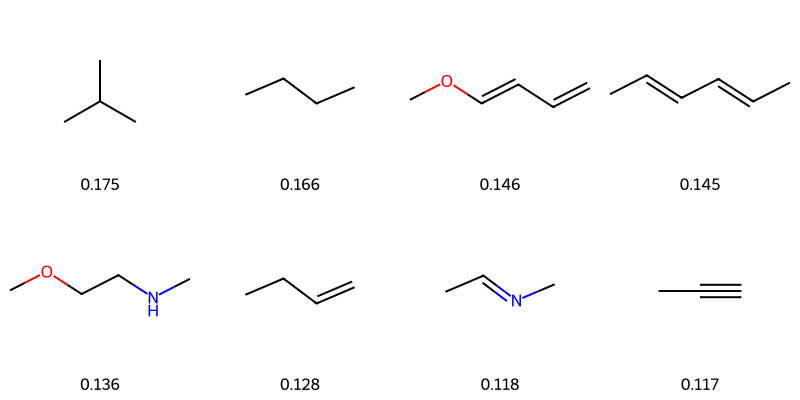


🔍 Schema 3


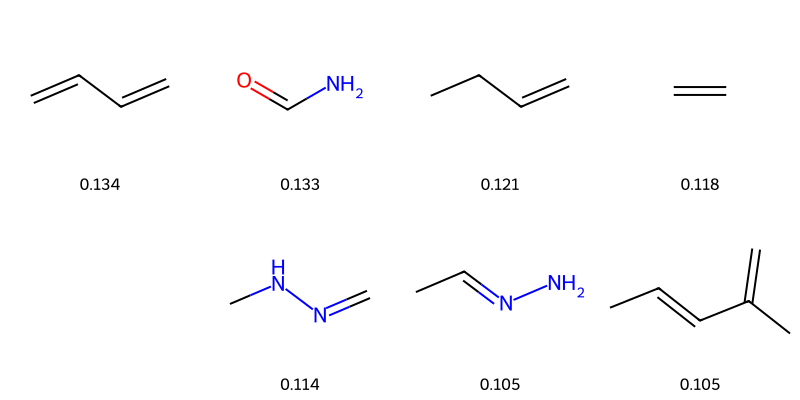


🔍 Schema 4


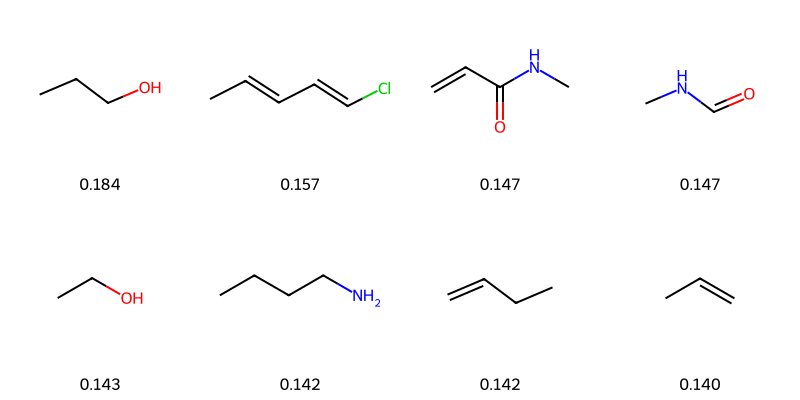


🔍 Schema 5


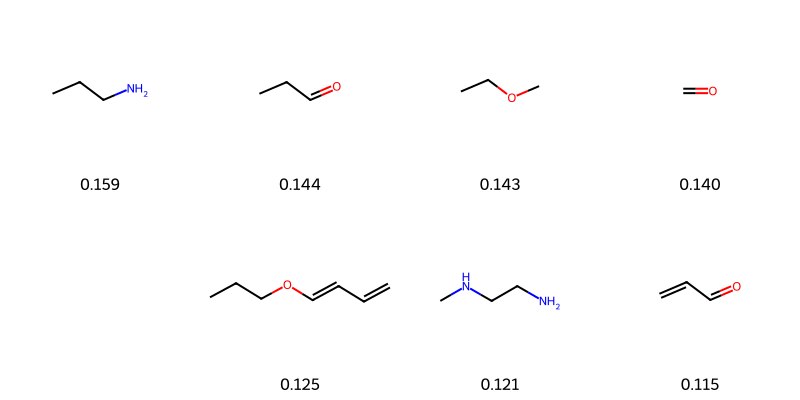


🔍 Schema 6


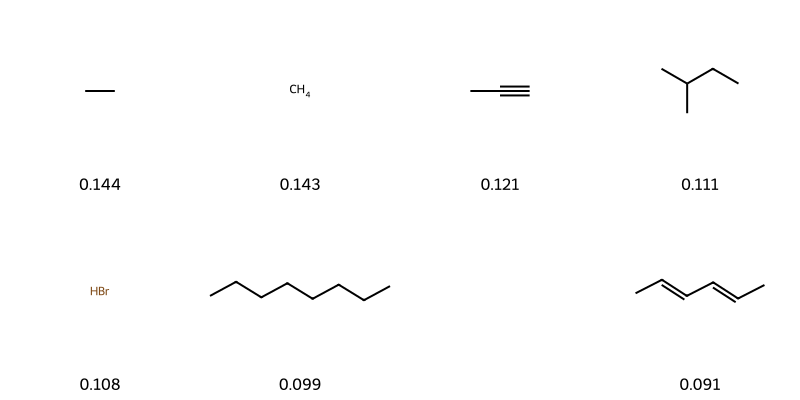


🔍 Schema 7


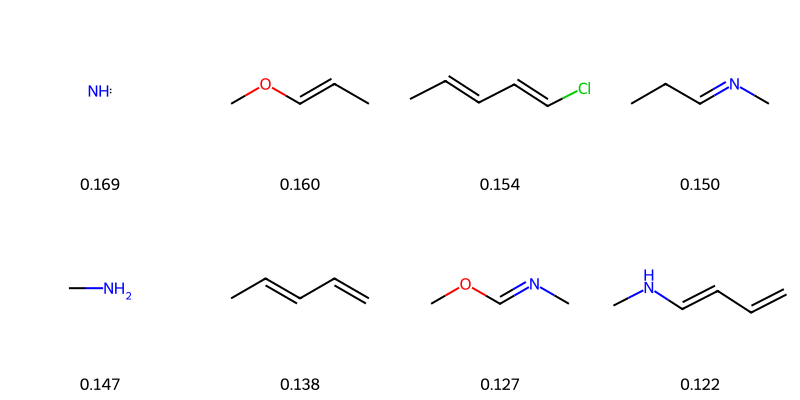


🔍 Schema 8


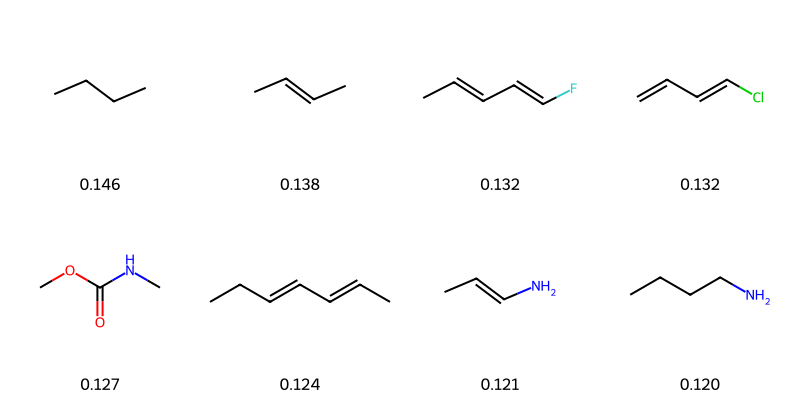


🔍 Schema 9


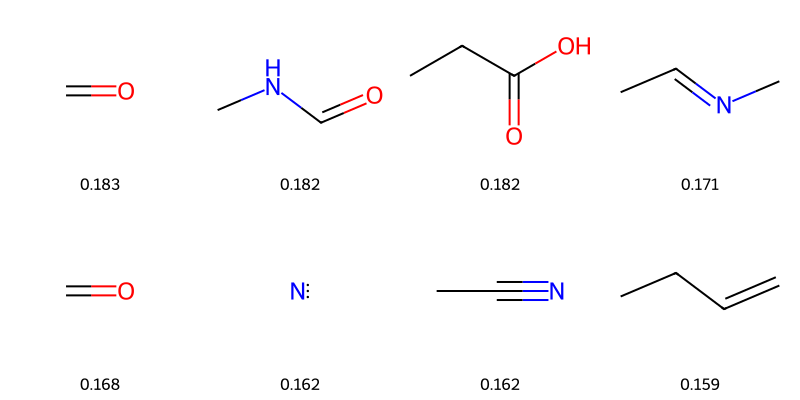


🔍 Schema 10


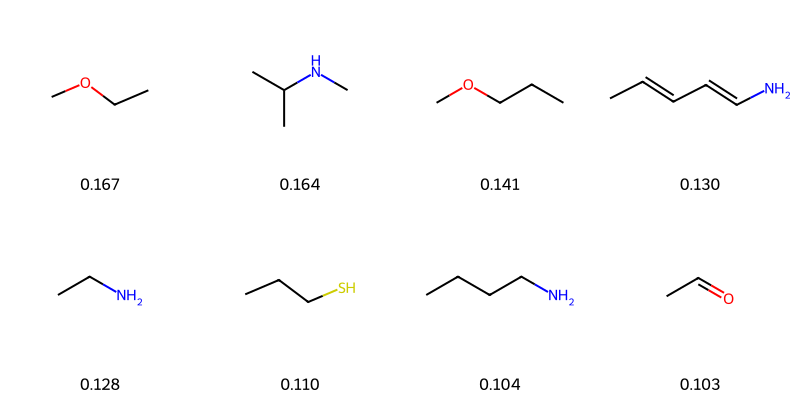


🔍 Schema 11


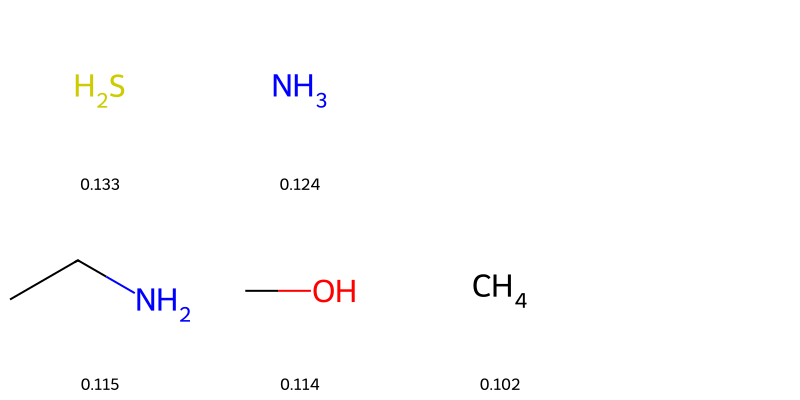


🔍 Schema 12


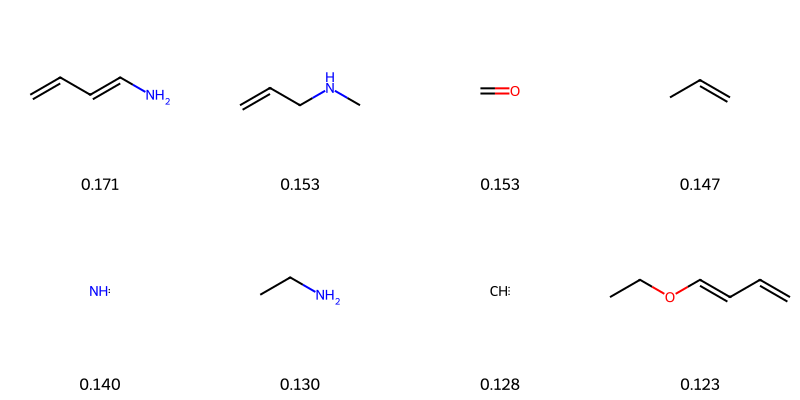


🔍 Schema 13


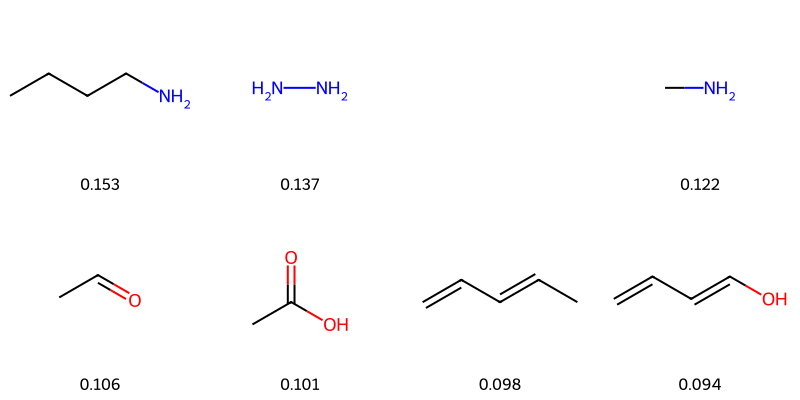


🔍 Schema 14


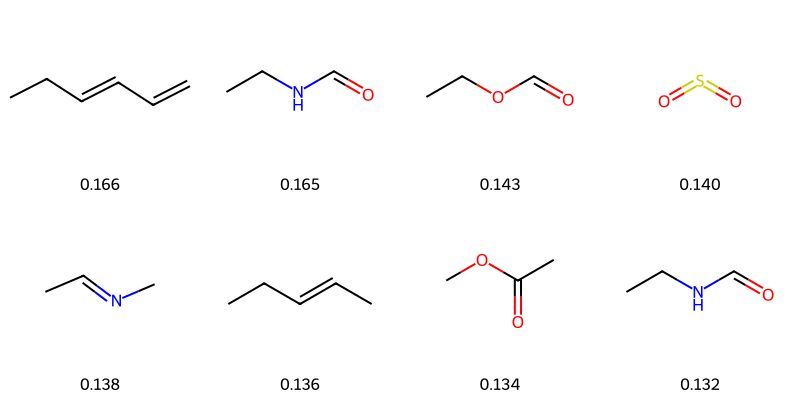


🔍 Schema 15


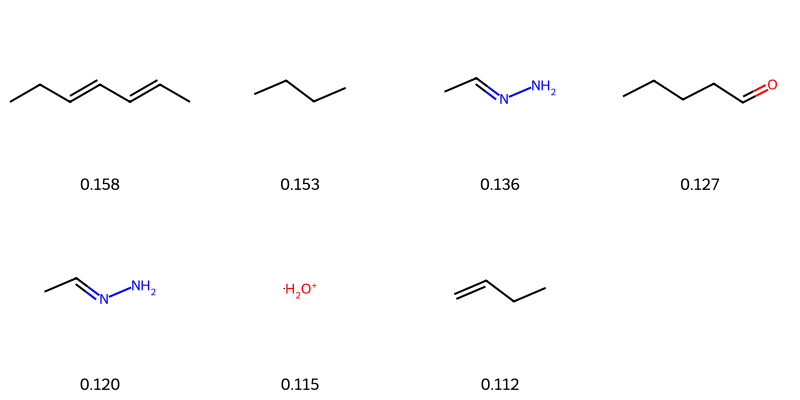


🔍 Schema 16


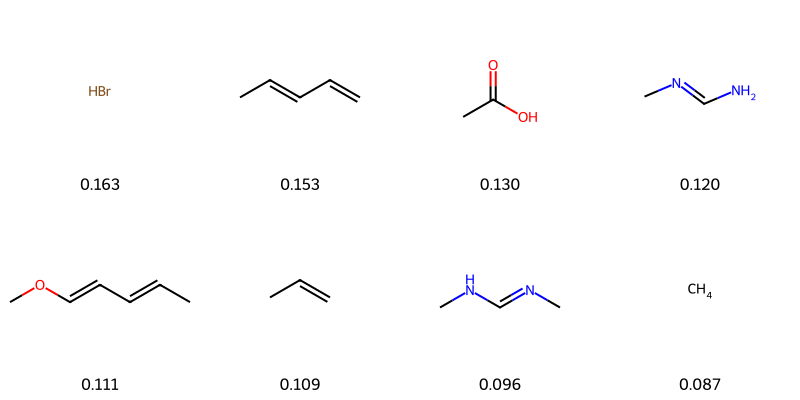


🔍 Schema 17


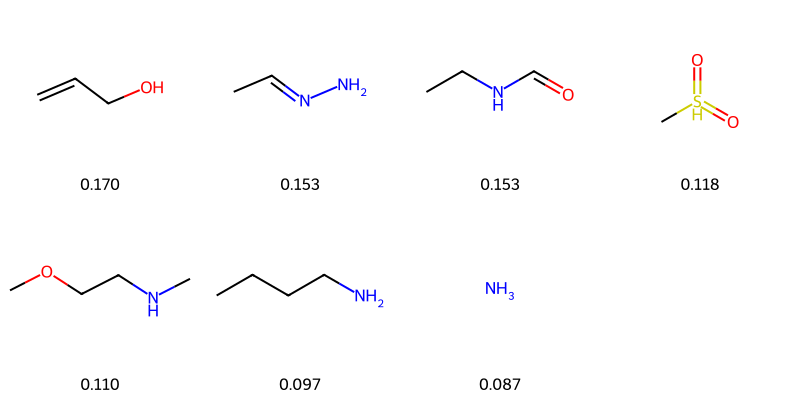


🔍 Schema 18


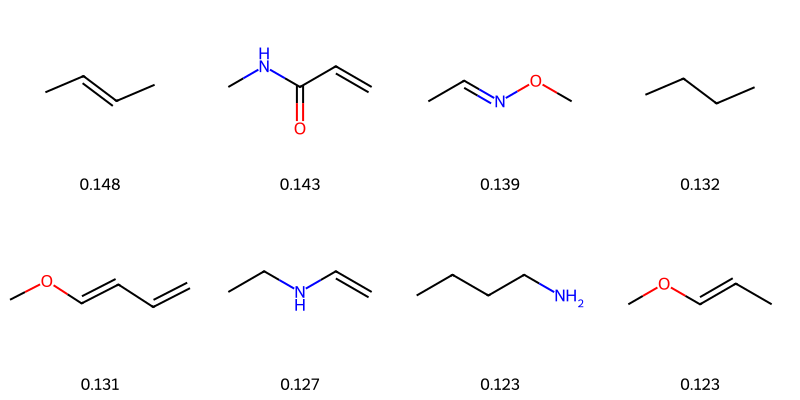


🔍 Schema 19


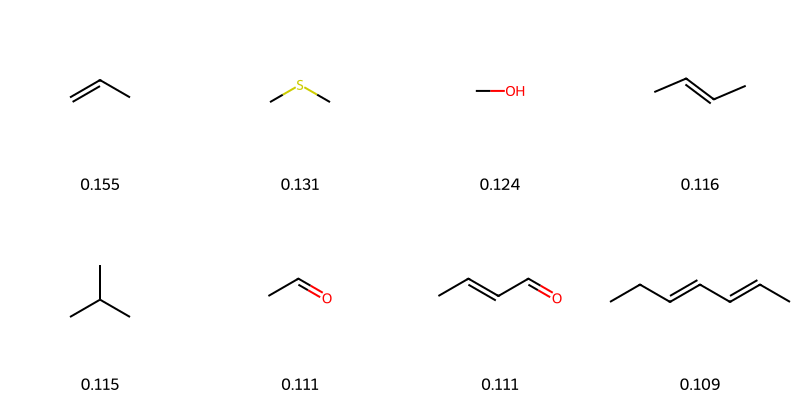


🔍 Schema 20


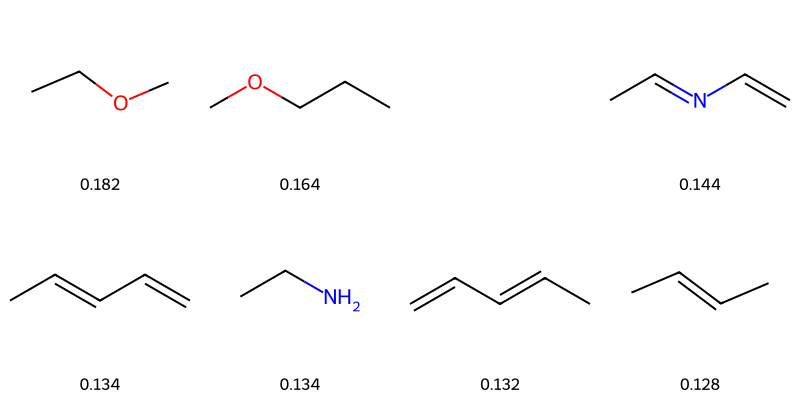


🔍 Schema 21


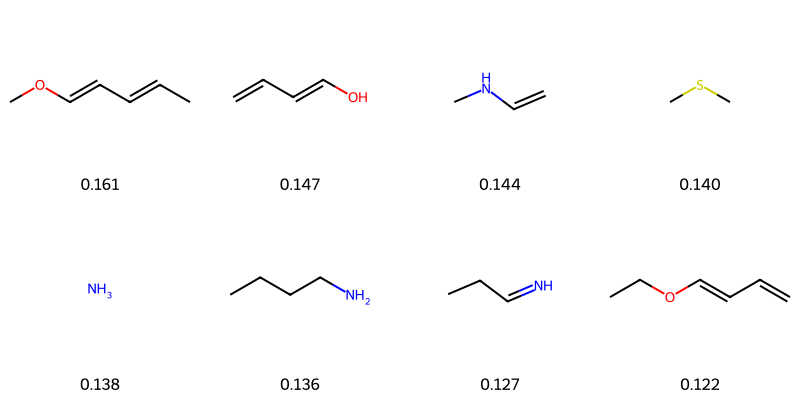


🔍 Schema 22


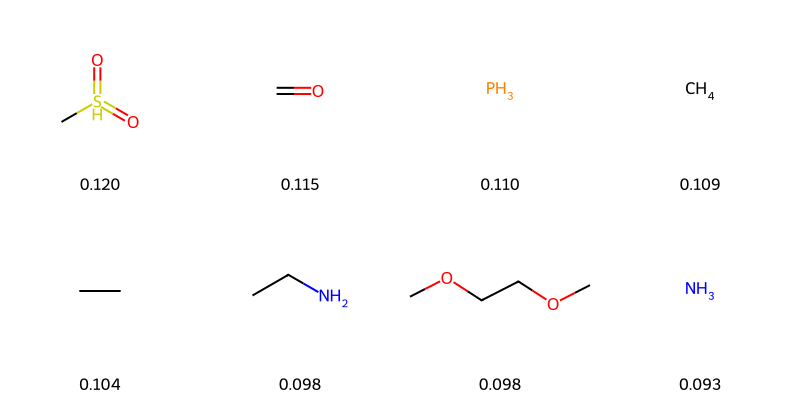


🔍 Schema 23


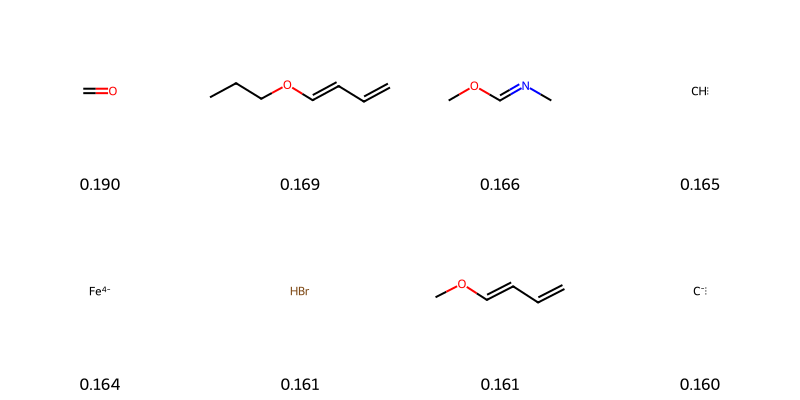


🔍 Schema 24


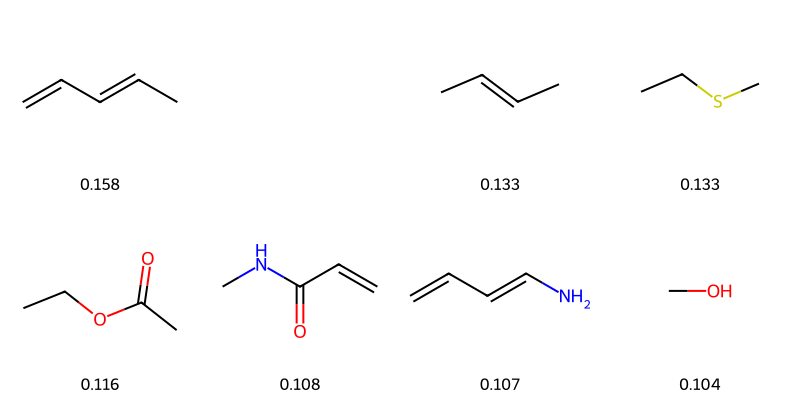


🔍 Schema 25


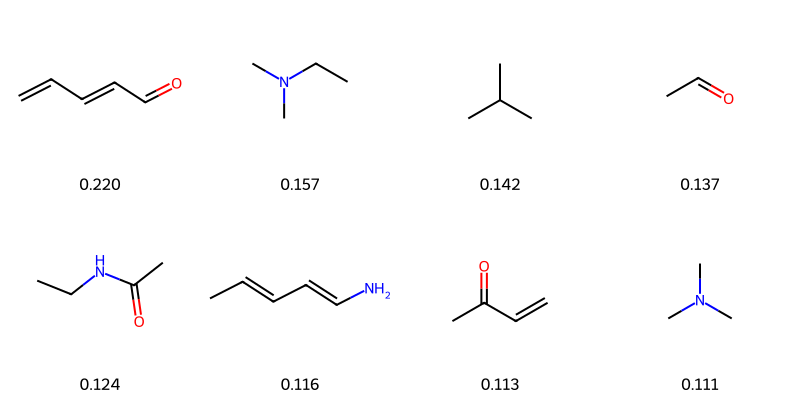


🔍 Schema 26


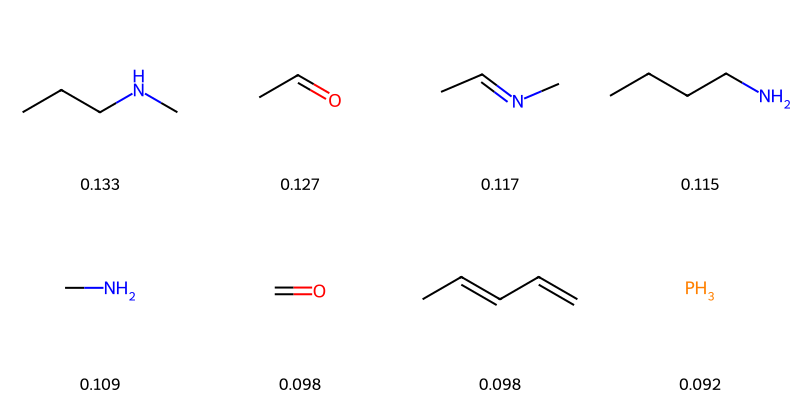


🔍 Schema 27


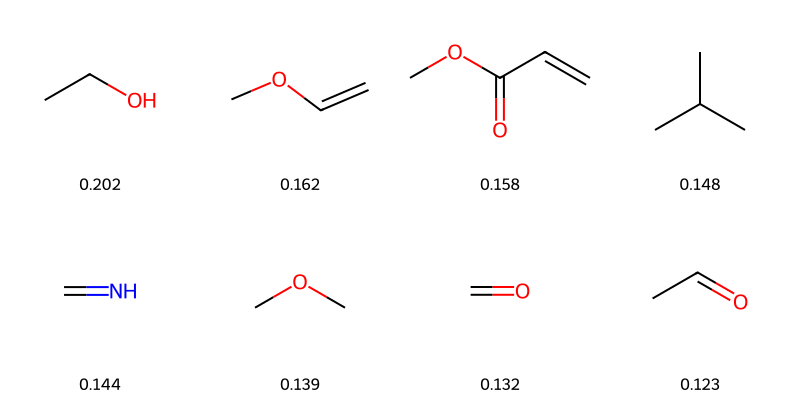


🔍 Schema 28


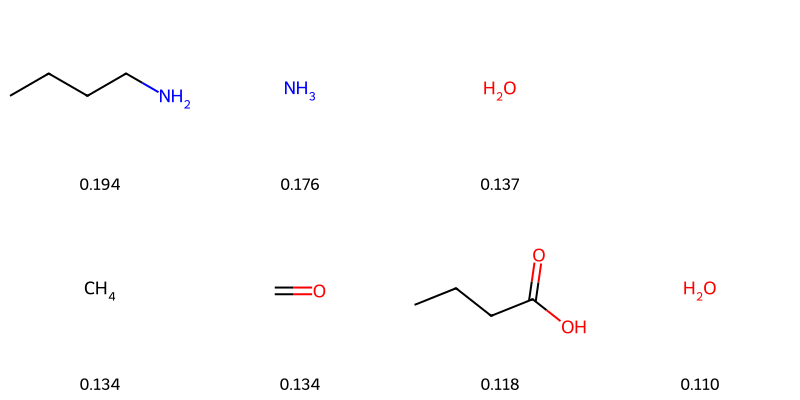


🔍 Schema 29


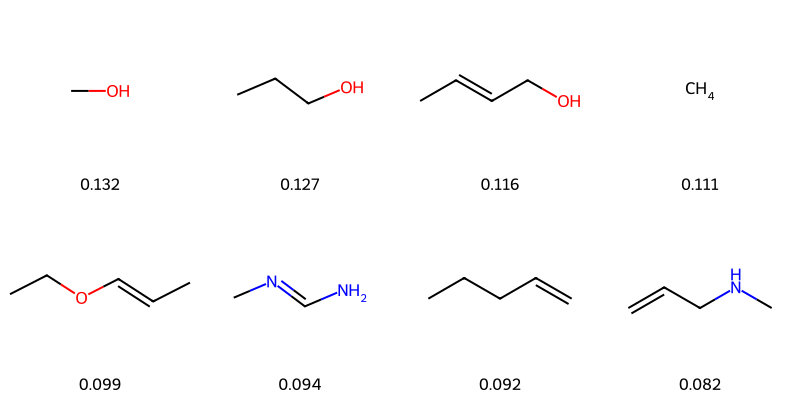


🔍 Schema 30


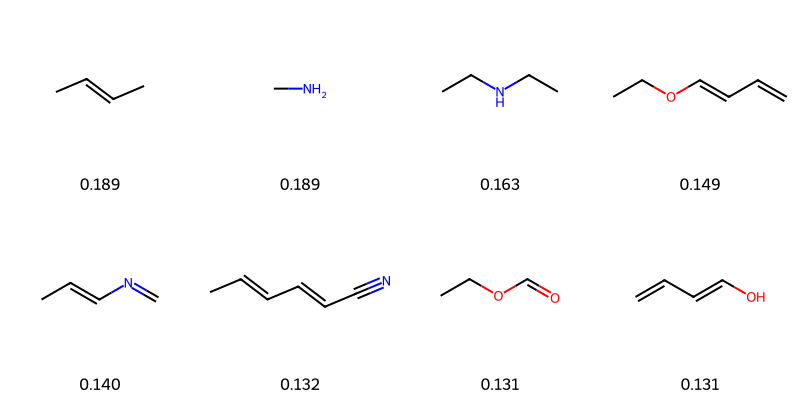


🔍 Schema 31


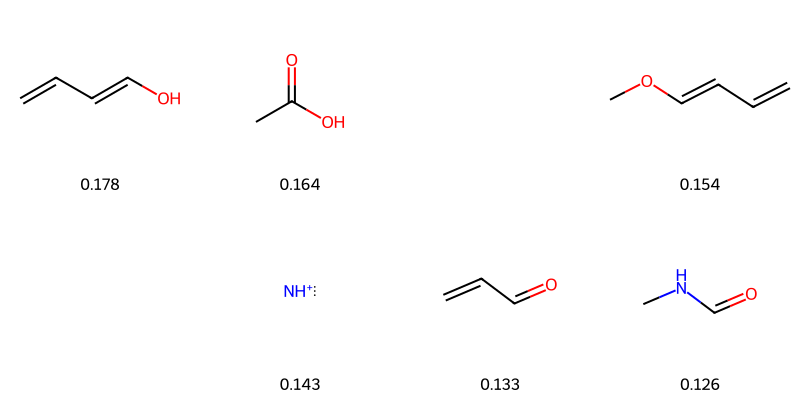

In [7]:
import torch
import torch.nn.functional as F
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")  # suppress RDKit warnings

@torch.no_grad()
def get_schema_top_tokens(model, tokenizer, top_k=8):
    model.eval()
    device = next(model.parameters()).device

    embed_matrix = model.embed.weight.data  # (V, D)
    projected_tokens = model.key_proj(embed_matrix)  # (V, D)

    schema_norm = F.normalize(model.schema_keys, p=2, dim=-1)  # (S, D)
    token_norm = F.normalize(projected_tokens, p=2, dim=-1)     # (V, D)

    sim = torch.mm(schema_norm, token_norm.T)  # (S, V)

    results = []
    for i in range(sim.size(0)):
        top_vals, top_ids = torch.topk(sim[i], k=top_k, largest=True)
        tokens_list = []
        for tid, val in zip(top_ids, top_vals):
            token_str = tokenizer.decode([tid.item()])
            tokens_list.append((token_str, val.item()))
        results.append(tokens_list)
    return results

def render_schema_molecules(schema_results, max_mols_per_schema=8):
    for schema_idx, token_entries in enumerate(schema_results):
        print(f"\n🔍 Schema {schema_idx}")
        mols = []
        labels = []

        for token_str, similarity in token_entries[:max_mols_per_schema]:
            # Clean token string: remove spaces, ensure valid SELFIES
            selfies_str = token_str.replace(" ", "")
            
            try:
                # Decode SELFIES → SMILES
                smiles = sf.decoder(selfies_str)
                
                # Convert SMILES → RDKit Mol
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    raise ValueError("Invalid SMILES")
                
                mols.append(mol)
                labels.append(f"{similarity:.3f}")
                
            except Exception as e:
                # If decoding fails, show placeholder
                print(f"⚠️  Failed to decode: '{token_str}' → {e}")
                # Optionally append a dummy molecule or skip
                continue

        if mols:
            # Render grid
            img = Draw.MolsToGridImage(
                mols,
                molsPerRow=min(len(mols), 4),
                subImgSize=(200, 200),
                legends=labels,
                useSVG=False  # set True if you prefer SVG
            )
            display(img)
        else:
            print("❌ No valid molecules to display for this schema.")

schema_results = get_schema_top_tokens(model, tokenizer, top_k=8)
render_schema_molecules(schema_results)

In [9]:
visualize_schemas_enhanced(
    model=model,
    tokenizer=tokenizer,
    top_k=10,
    mask_stop=True,
    export="html",  # or "latex"
    export_path=f"{model_path}/schemas_viz.html"
)


Schema 00: [C] [N] [C] [C] (0.556) | [C] [N] [C] [=C] (0.513) | [C] [C] [C] [N] (0.457) | [N] [C] [C] [C] [C] (0.440) | [Branch1] (0.436) | [N] (0.429) | [C] [C] (0.423) | [N] [C] [=C] [C] [=C] (0.419) | [C] [C] [C] [C] [C] [C] (0.406)
Schema 01: [N] (0.576) | [N] [C] [C] [C] [C] (0.473) | [C] [O] [C] (0.471) | [=N] (0.469) | [=C] (0.450) | [Branch1] (0.446) | [C] [C] [C] [Branch1] (0.443) | [Ring2] (0.439) | [C] [N] [C] [C] (0.435)
Schema 02: [C] [N] [C] [C] (0.563) | [N] [C] [C] [C] [C] (0.500) | [N] (0.484) | [Branch1] (0.458) | [=N] (0.457) | [=C] (0.434) | [N] [C] [=Branch1] [C] [=O] [C] (0.428) | [C] [C] [C] [C] (0.423) | [C] [C] [C] [N] (0.406)
Schema 03: [Ring2] (0.594) | [C] [O] [C] (0.587) | [N] (0.568) | [=C] (0.525) | [P] (0.487) | [C] [=C] [C] [=C] [C] (0.483) | [C] [C] [C] [Branch1] (0.478) | [N] [C] [=Branch1] [C] [=O] [C] (0.475) | [C] [C] [=Branch1] [C] [=O] [O] [C] (0.472)
Schema 04: [Branch1] (0.616) | <s> (0.610) | [N] (0.607) | [C] [C] (0.597) | [Ring1] (0.558) | [

🔍 Found 24 redundant schema pairs (cos>0.95)
  Schema 0 ↔ 8: 0.984
  Schema 0 ↔ 9: 0.966
  Schema 0 ↔ 12: 0.966
  Schema 0 ↔ 13: 0.951
  Schema 0 ↔ 31: 0.964
  Schema 1 ↔ 21: 0.972
  Schema 3 ↔ 6: 0.955
  Schema 3 ↔ 10: 0.957
  Schema 7 ↔ 12: 0.957
  Schema 7 ↔ 30: 0.964


d:\ProgramData\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


💡 Avg intra-cluster cosine: 0.749
✅ Saved schema analysis → ./checkpoints_1/somt_mol_run_0//schema_analysis.json


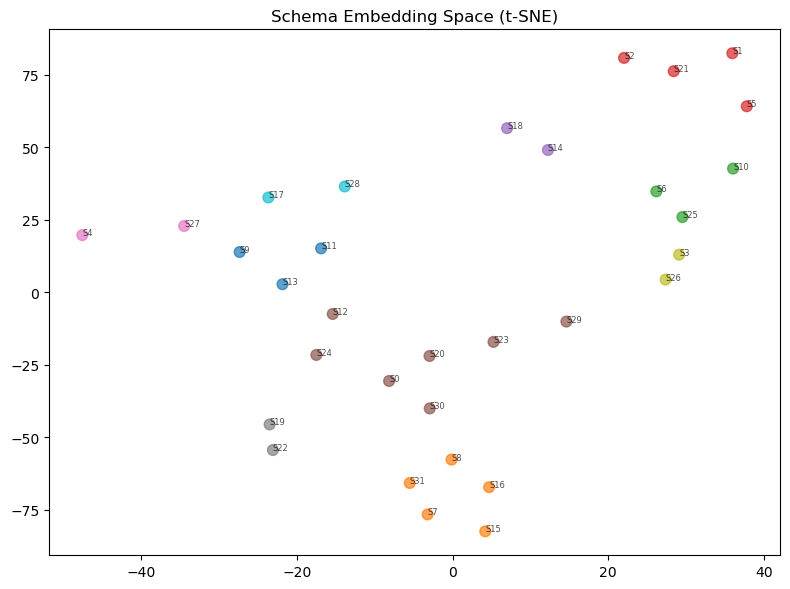

{'positions': [[-8.154644966125488, -30.589595794677734], [35.922142028808594, 82.3615493774414], [22.016225814819336, 80.75552368164062], [29.08783721923828, 12.934749603271484], [-47.54735565185547, 19.66744613647461], [37.77641677856445, 64.07931518554688], [26.163856506347656, 34.74952697753906], [-3.207542896270752, -76.58143615722656], [-0.13669265806674957, -57.68619155883789], [-27.350784301757812, 13.851001739501953], [36.012237548828125, 42.59950256347656], [-16.88552474975586, 15.107030868530273], [-15.392637252807617, -7.499777317047119], [-21.844863891601562, 2.744927167892456], [12.244324684143066, 48.998931884765625], [4.1944260597229, -82.42124938964844], [4.689818859100342, -67.18810272216797], [-23.65807342529297, 32.64997100830078], [6.992504119873047, 56.52648162841797], [-23.496599197387695, -45.56184387207031], [-2.9598488807678223, -21.976179122924805], [28.394495010375977, 76.17021179199219], [-23.076690673828125, -54.38656997680664], [5.256600856781006, -17.117

In [10]:
analysis = analyze_schemas(model, tokenizer, top_k=10, save_path=f"{model_path}/schema_analysis.json")
print(analysis)  # Print the analysis summary

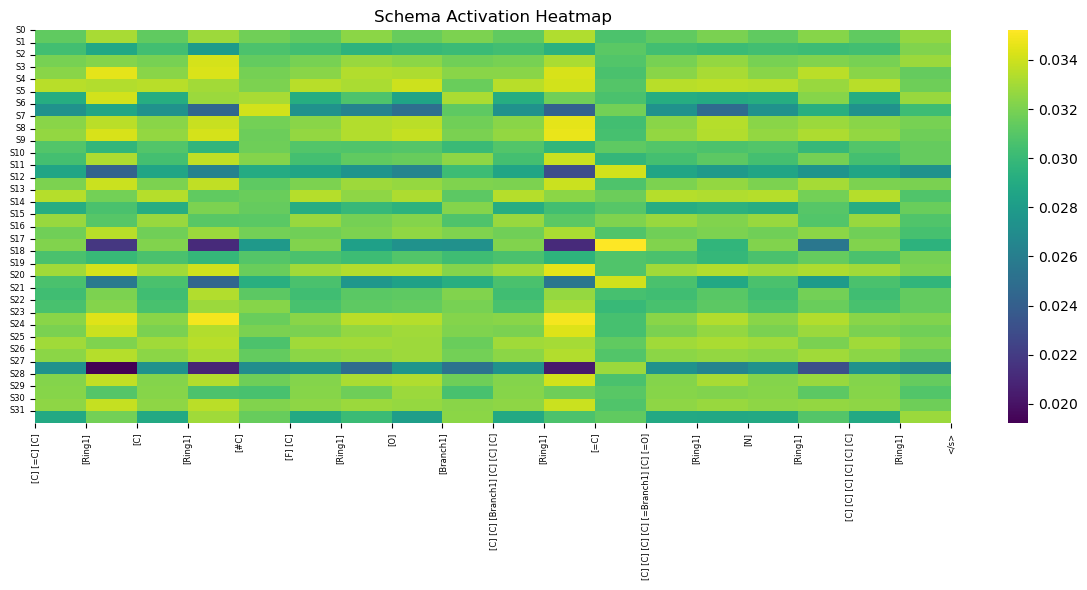

[C] [=C] [C] [Ring1] [C] [Ring1] [#C] [F] [C] [Ring1] [O] [Branch1] [C] [C] [Branch1] [C] [C] [C] [Ring1] [=C] [C] [C] [C] [C] [=Branch1] [C] [=O] [Ring1] [N] [Ring1] [C] [C] [C] [C] [C] [C] [Ring1]


In [7]:
result = generate_with_schema_attribution(
    model,
    tokenizer,
    prompt="[C] [=C] [C]",
    max_len=60,
    temperature=0.8,
    visualize_heatmap=True
)
print(result['text'])

In [5]:
schema_ablation_test(model, tokenizer, prompt="[C] [=C] [C] [Branch2] [C] [C] [Branch1] [C] [C] [C] [C] [Ring1]", max_len=40)



=== Schema Ablation ΔPPL ===
schema_0: +22.7314
schema_1: +22.0041
schema_2: +24.6759
schema_3: +18.8998
schema_4: +25.0790
schema_5: +21.9881
schema_6: +21.9487
schema_7: +23.2643
schema_8: +23.0936
schema_9: +21.9952
schema_10: +23.3669
schema_11: +21.9373
schema_12: +22.3318
schema_13: +22.3284
schema_14: +22.0033
schema_15: +22.2237
schema_16: +21.9531
schema_17: +21.9503
schema_18: +21.9727
schema_19: +23.4398
schema_20: +21.9488
schema_21: +22.5149
schema_22: +22.6229
schema_23: +21.0096
schema_24: +23.1771
schema_25: +24.0422
schema_26: +23.3615
schema_27: +21.9487
schema_28: +22.4667
schema_29: +22.3398
schema_30: +23.2065
schema_31: +21.9813


{'schema_0': 22.73139190673828,
 'schema_1': 22.00414276123047,
 'schema_2': 24.675865173339844,
 'schema_3': 18.89984893798828,
 'schema_4': 25.07903289794922,
 'schema_5': 21.988121032714844,
 'schema_6': 21.94866180419922,
 'schema_7': 23.26428985595703,
 'schema_8': 23.09362030029297,
 'schema_9': 21.995216369628906,
 'schema_10': 23.366859436035156,
 'schema_11': 21.937294006347656,
 'schema_12': 22.331809997558594,
 'schema_13': 22.32837677001953,
 'schema_14': 22.00328826904297,
 'schema_15': 22.22370147705078,
 'schema_16': 21.953102111816406,
 'schema_17': 21.95030975341797,
 'schema_18': 21.972694396972656,
 'schema_19': 23.439842224121094,
 'schema_20': 21.94879913330078,
 'schema_21': 22.51488494873047,
 'schema_22': 22.62285614013672,
 'schema_23': 21.009605407714844,
 'schema_24': 23.17705535888672,
 'schema_25': 24.042198181152344,
 'schema_26': 23.361534118652344,
 'schema_27': 21.94873809814453,
 'schema_28': 22.46668243408203,
 'schema_29': 22.33983612060547,
 'schema